<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/sps_logreg_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Polyak Stepsize

https://github.com/IssamLaradji/sps/


## Setup

In [1]:
!pip install git+https://github.com/IssamLaradji/sps.git



  Cloning https://github.com/IssamLaradji/sps.git to /tmp/pip-req-build-60uxcgbo
  Running command git clone -q https://github.com/IssamLaradji/sps.git /tmp/pip-req-build-60uxcgbo
  Created wheel for sps: filename=sps-0.6.0-cp37-none-any.whl size=2755 sha256=c80725a4e4462d6fa72c1e76f0d3c948c4e219d6683eb2edcc00a2ddd0b56ce4
  Stored in directory: /tmp/pip-ephem-wheel-cache-pna_j6wu/wheels/45/3c/39/489a550c0925358bf72c824a5cc59e59f2cdc8f50ce775bcef
Successfully built sps


'\nimport sps\nopt = sps.Sps(model.parameters())\n\nfor epoch in range(100):\n    for X, y in loader:\n        # create loss closure\n        def closure():\n          loss = torch.nn.MSELoss()(model(X), y)\n          loss.backward()\n          return loss\n\n        # update parameters\n        opt.zero_grad()\n        opt.step(closure=closure)\n'

In [3]:
import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os

import numpy as np
from scipy.special import logsumexp
np.set_printoptions(precision=3)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [4]:


import torch
import torch.nn as nn
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

torch version 1.8.0+cu101
Tesla P100-PCIE-16GB
current device 0


## Binary logistic regression using Sklearn

In [20]:
# Fit the model usign sklearn

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"]
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)

# extract probability of class 1
pred_sklearn_train = log_reg.predict_proba(X_train)[:,1]
pred_sklearn_test = log_reg.predict_proba(X_test)[:,1]

w_mle_sklearn = np.ravel(log_reg.coef_)
print(w_mle_sklearn)

[-4.414 -9.111 6.539 12.686]


## PyTorch data and model

In [6]:
from torch.utils.data import DataLoader, TensorDataset

# data. By default, numpy uses double but torch uses float
X_train_t = torch.tensor(X_train,  dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.float)

X_test_t = torch.tensor(X_test, dtype=torch.float)
y_test_t = torch.tensor(y_test, dtype=torch.float)

# To make things interesting, we pick a batchsize of B=33, which is not divisible by N=100
dataset = TensorDataset(X_train_t, y_train_t)
B = 33
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)

In [12]:

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(D, 1, bias=False) 
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred[:,0] # (N,1) -> (N)

In [60]:
def criterion(ypred, ytrue, L2reg=0):
  loss = torch.nn.BCELoss(reduction='mean')(ypred, ytrue)
  w = 0.
  for p in model.parameters():
    w += (p**2).sum()
  loss += L2reg * w
  return loss



## BFGS

In [53]:
set_seed(0)
model = Model()
loss_trace = []
optimizer = torch.optim.LBFGS(model.parameters(), history_size=10)
    
def closure():
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t, L2reg=0)
    loss.backward()
    return loss.item()

max_iter = 10
for i in range(max_iter):
    loss = optimizer.step(closure)
    loss_trace.append(loss)

predicitons on test set using sklearn
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
predicitons on test set using sgd
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]


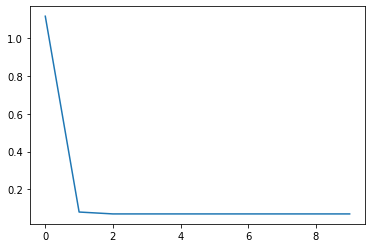

In [54]:
plt.figure()
plt.plot(loss_trace)

pred_sgd_train = model(X_train_t).detach().numpy() 
pred_sgd_test = model(X_test_t).detach().numpy() 


print('predicitons on test set using sklearn')
print(pred_sklearn_test)
print('predicitons on test set using sgd')
print(pred_sgd_test)

In [57]:
set_seed(0)
model = Model()
loss_trace = []
optimizer = torch.optim.LBFGS(model.parameters(), history_size=10)
    
def closure():
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t, L2reg=1e-4)
    loss.backward()
    return loss.item()

max_iter = 10
for i in range(max_iter):
    loss = optimizer.step(closure)
    loss_trace.append(loss)

predicitons on test set using sklearn
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
predicitons on test set using sgd
[0.012 0.000 1.000 0.039 0.009 0.000 0.000 0.907 0.617 0.001 0.634 0.000
 0.000 0.000 0.000 0.008 0.999 0.003 0.040 1.000 0.000 0.619 0.000 0.999
 0.205 0.985 0.998 0.998 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.986
 0.001 0.000 0.000 0.000 0.995 0.004 0.003 0.000 0.000 0.001 0.387 0.877
 0.001 0.994]


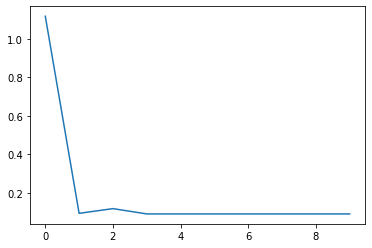

In [58]:
plt.figure()
plt.plot(loss_trace)

pred_sgd_train = model(X_train_t).detach().numpy() 
pred_sgd_test = model(X_test_t).detach().numpy() 


print('predicitons on test set using sklearn')
print(pred_sklearn_test)
print('predicitons on test set using sgd')
print(pred_sgd_test)

## SGD

In [79]:
nepochs = 100
learning_rate = 1e-1
loss_trace = []

set_seed(0)
model = Model()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    
for epoch in range(nepochs):
  for X, y in dataloader:
    y_pred = model(X) 
    loss = criterion(y_pred, y, L2reg=0)
    loss_trace.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  


predicitons on test set using sklearn
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
predicitons on test set using sgd
[0.067 0.000 0.836 0.072 0.036 0.000 0.015 0.148 0.145 0.024 0.151 0.000
 0.000 0.000 0.000 0.043 0.615 0.038 0.098 0.628 0.000 0.183 0.000 0.587
 0.096 0.264 0.562 0.505 0.000 0.000 0.000 0.000 0.011 0.000 0.000 0.342
 0.024 0.000 0.000 0.000 0.527 0.040 0.026 0.000 0.000 0.029 0.169 0.298
 0.016 0.370]


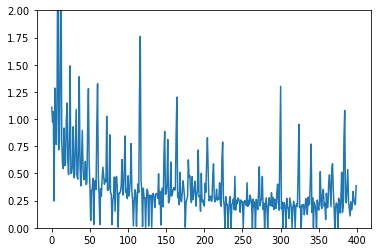

In [80]:
plt.figure()
plt.plot(loss_trace)
plt.ylim([0, 2])

pred_sgd_train = model(X_train_t).detach().numpy() 
pred_sgd_test = model(X_test_t).detach().numpy() 


print('predicitons on test set using sklearn')
print(pred_sklearn_test)
print('predicitons on test set using sgd')
print(pred_sgd_test)

## Momentum

In [81]:
nepochs = 100
loss_trace = []

set_seed(0)
model = Model()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    
for epoch in range(nepochs):
  for X, y in dataloader:
    y_pred = model(X) 
    loss = criterion(y_pred, y, L2reg=0)
    loss_trace.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  

predicitons on test set using sklearn
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
predicitons on test set using sgd
[0.364 0.000 0.988 0.374 0.258 0.000 0.086 0.643 0.565 0.138 0.630 0.000
 0.000 0.000 0.000 0.279 0.945 0.200 0.439 0.944 0.000 0.654 0.000 0.934
 0.626 0.783 0.931 0.922 0.000 0.000 0.000 0.000 0.090 0.000 0.000 0.819
 0.169 0.000 0.000 0.000 0.901 0.247 0.193 0.000 0.000 0.152 0.644 0.808
 0.119 0.886]


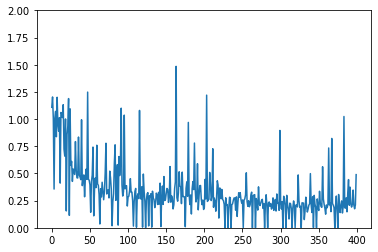

In [82]:
plt.figure()
plt.plot(loss_trace)
plt.ylim([0, 2])

pred_sgd_train = model(X_train_t).detach().numpy() 
pred_sgd_test = model(X_test_t).detach().numpy() 


print('predicitons on test set using sklearn')
print(pred_sklearn_test)
print('predicitons on test set using sgd')
print(pred_sgd_test)

## SPS

In [83]:
import sps

set_seed(0)
model = Model()
score_list = []

opt = sps.Sps(model.parameters(), c=0.5, eta_max=1, 
              adapt_flag='constant') 
#, fstar_flag=True)
 #c=0.2 blows up

nepochs = 100
for epoch in range(nepochs):
  for X, y in dataloader:

    def closure():
      loss = criterion(model(X), y, L2reg=1e-4)
      loss.backward()
      return loss

    opt.zero_grad()
    loss = opt.step(closure=closure)
    loss_trace.append(loss)
   
    # Record metrics
    score_dict = {"epoch": epoch}
    score_dict["step_size"] = opt.state.get("step_size", {})
    score_dict["step_size_avg"] = opt.state.get("step_size_avg", {})
    score_dict["train_loss"] = loss

    score_list += [score_dict]

In [84]:
import pandas as pd
df = pd.DataFrame(score_list)
df.head()

,epoch,step_size,step_size_avg,train_loss
0,0,1.000000,{},1.108342
1,0,0.529432,{},4.244390
2,0,0.779594,{},2.529669
3,0,0.229849,{},7.696729
4,1,0.559647,{},2.745134


predicitons on test set using sklearn
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
predicitons on test set using sgd
[0.034 0.000 0.999 0.044 0.012 0.000 0.001 0.310 0.203 0.003 0.270 0.000
 0.000 0.000 0.000 0.016 0.977 0.008 0.074 0.979 0.000 0.332 0.000 0.969
 0.157 0.663 0.961 0.949 0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.769
 0.004 0.000 0.000 0.000 0.935 0.012 0.006 0.000 0.000 0.004 0.279 0.679
 0.002 0.875]


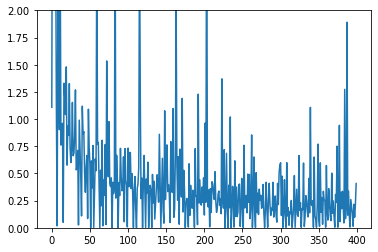

In [85]:
plt.figure()
plt.plot(df["train_loss"])
plt.ylim([0, 2])

pred_sgd_train = model(X_train_t).detach().numpy() 
pred_sgd_test = model(X_test_t).detach().numpy() 

print('predicitons on test set using sklearn')
print(pred_sklearn_test)
print('predicitons on test set using sgd')
print(pred_sgd_test)

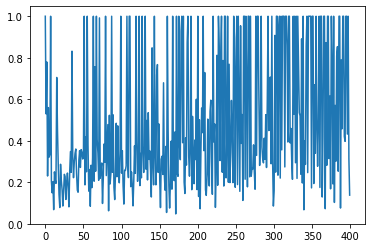

In [86]:
plt.figure()
plt.plot(df["step_size"])


